# LSTM boxcox lambda = 1.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  1000000 

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'pxpy', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.1368683772161603e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(800000, 6, 5) (800000, 6) (800000, 12)
(200000, 6, 5) (200000, 6) (200000, 12)


In [4]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(128, activation='tanh')(concat0)
    PreDense2 = Dense(64, activation='tanh')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='softmax')(PreDense2)
    Norm = Lambda(lambda x: tf.math.multiply(x, 4))(PreDense3) # 4 relevant jets
    Shape_Dot = Reshape((-1,1))(Norm)
    Dot_jets = Multiply()([Shape_Dot, Mask])
    
    TDDense11 = TimeDistributed(Dense(64, activation='relu'))(Dot_jets)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Sum = Flatten()(TDDense12)
    # Sum = Lambda(lambda x: tf.reduce_sum(x,1))(TDDense12)
    Dense13 = Dense(64, activation='relu')(Sum)
    flat_right = Flatten()(Dense13)
    
    
    Dense21 = Dense(64, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    dense1 = Dense(256, activation='relu')(concat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 30)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 36)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

In [7]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 512

# del X_total
# del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 640000 samples, validate on 160000 samples
Epoch 1/512
640000/640000 [==============================] - 10s 15us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 7/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0045 - ms

Epoch 58/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 59/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 60/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 61/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 62/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 63/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 64/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037

640000/640000 [==============================] - 8s 13us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 116/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 117/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 118/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 119/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 120/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 121/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 

Epoch 172/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 173/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 174/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 175/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 176/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 177/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 178/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse:

Epoch 229/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 230/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 231/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 232/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 233/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 234/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 235/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse:

Epoch 286/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 287/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 288/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 289/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 290/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 291/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 292/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse:

Epoch 343/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 344/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 345/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 346/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 347/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 348/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 349/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse:

Epoch 400/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 401/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 402/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 403/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 404/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 405/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 406/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse:

Epoch 457/512
640000/640000 [==============================] - 8s 12us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 458/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 459/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 460/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 461/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 462/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 463/512
640000/640000 [==============================] - 8s 13us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse:

Text(0.5, 1.0, 'MSE loss')

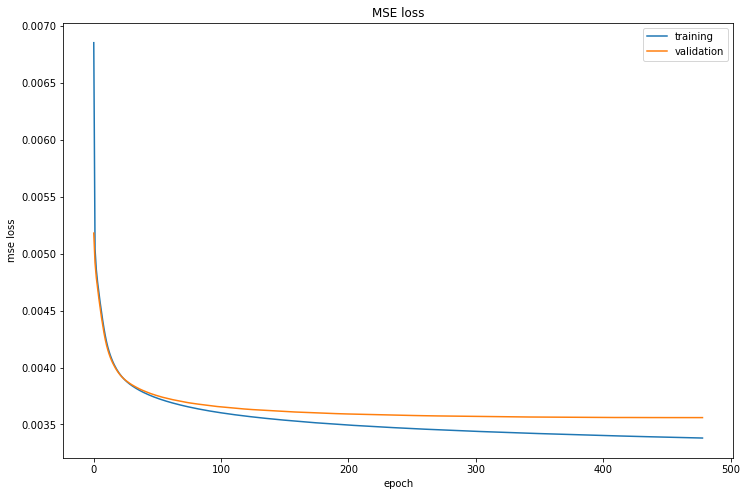

In [8]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [9]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [10]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.003562921316476004
 
th_px MSE :  0.0030747154
th_py MSE :  0.0048301647
th_eta MSE :  0.0067591412
th_m MSE :  0.0041391564
tl_px MSE :  0.0035875564
tl_py MSE :  0.0023123336
tl_eta MSE :  0.0034891526
tl_m MSE :  0.0045827515
wl_px MSE :  0.0013291559
wl_py MSE :  0.0009972353
wl_eta MSE :  0.0048986400
wl_m MSE :  0.0027550528


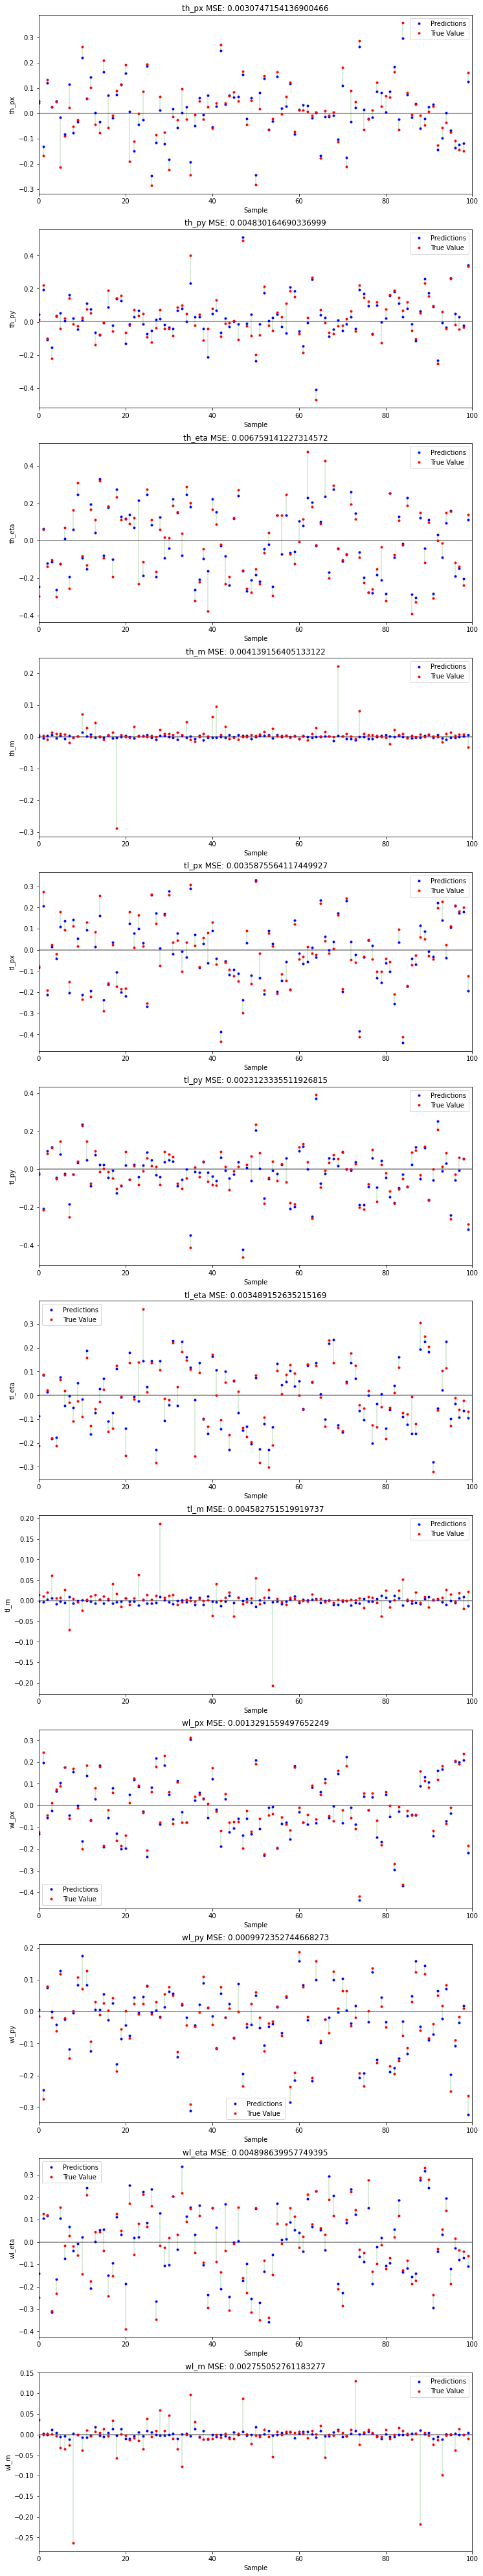

In [11]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

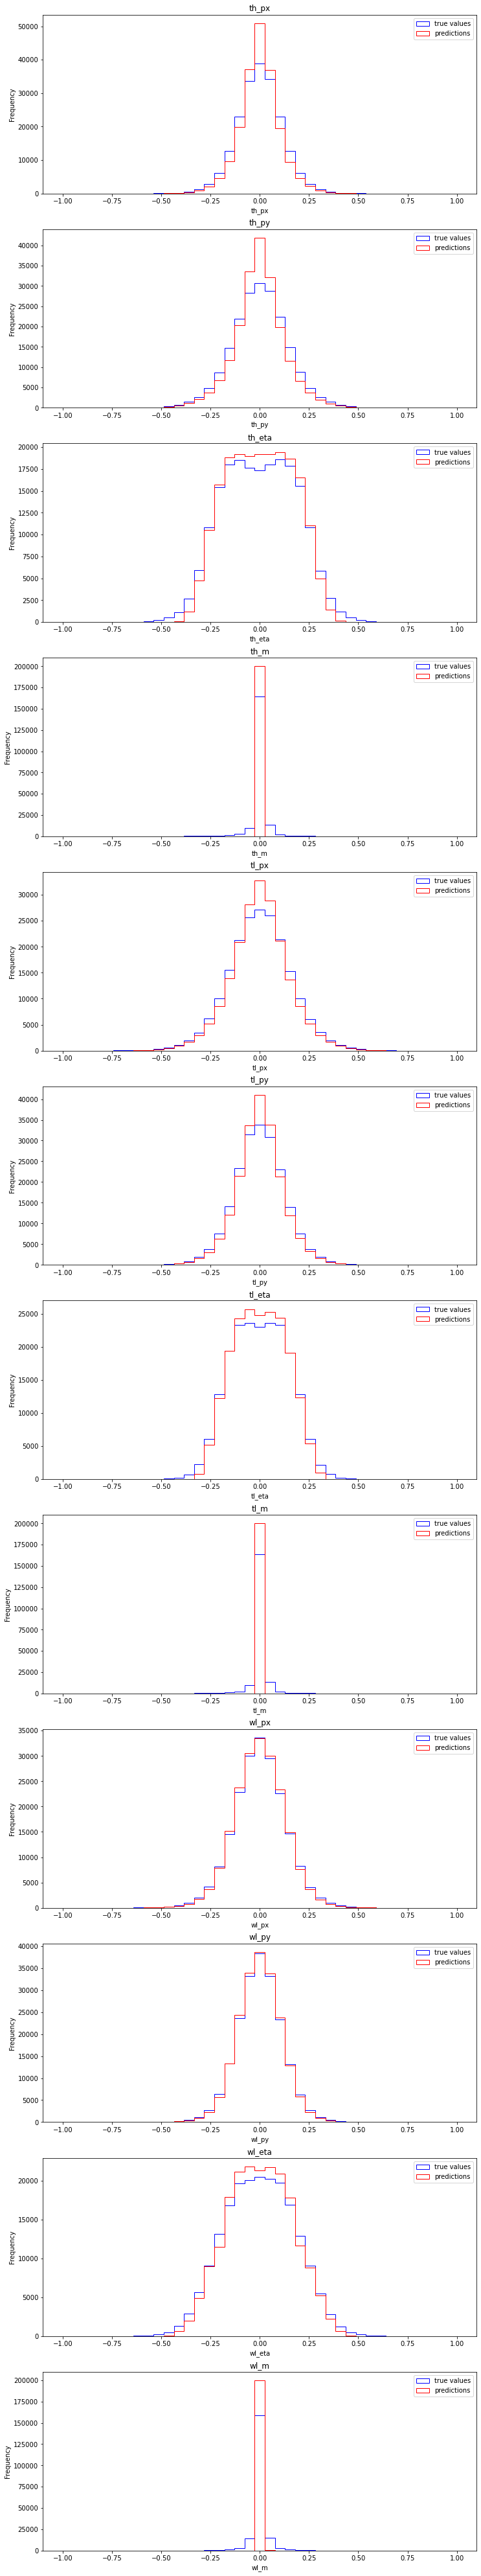

In [12]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

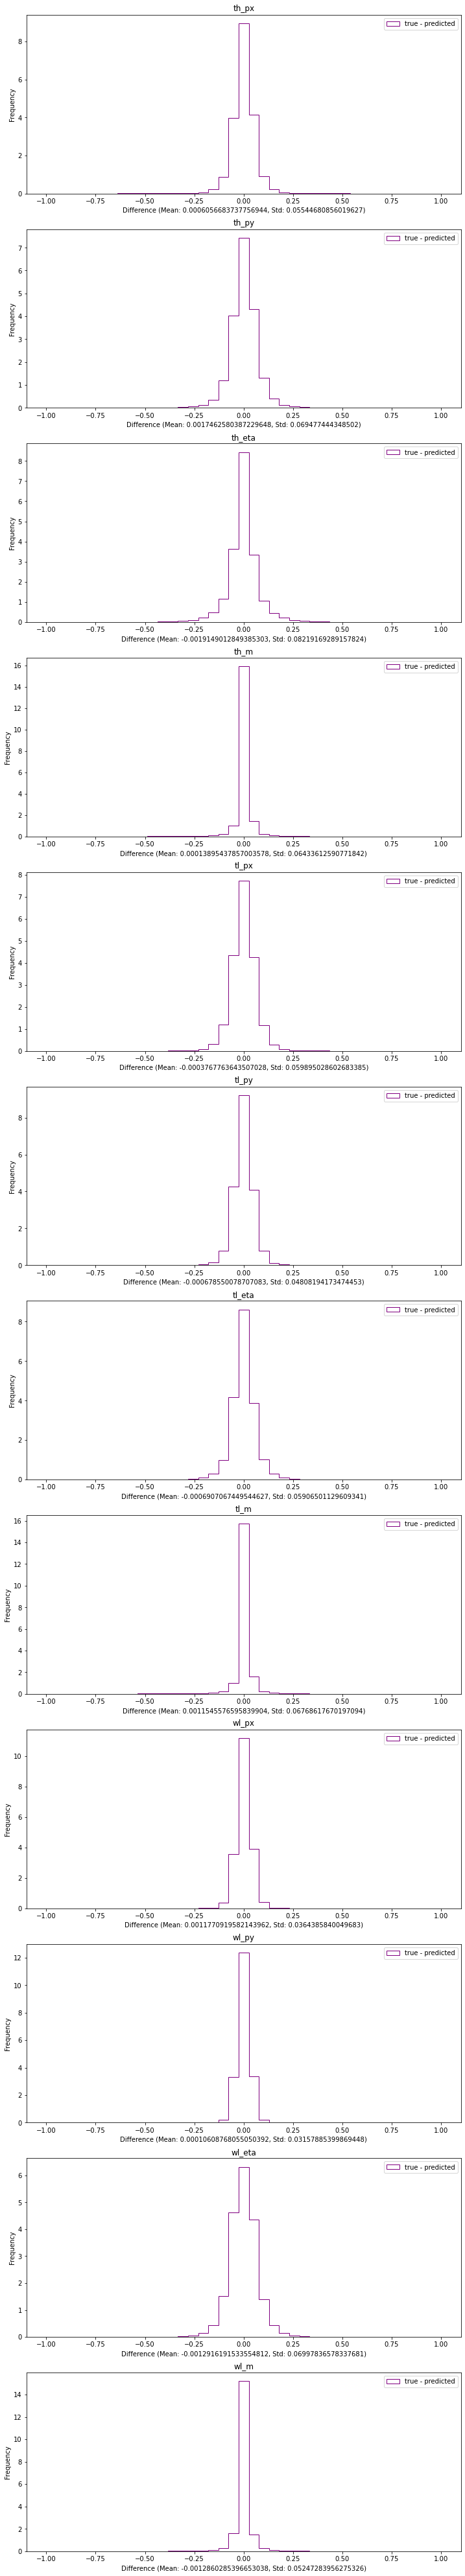

In [13]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

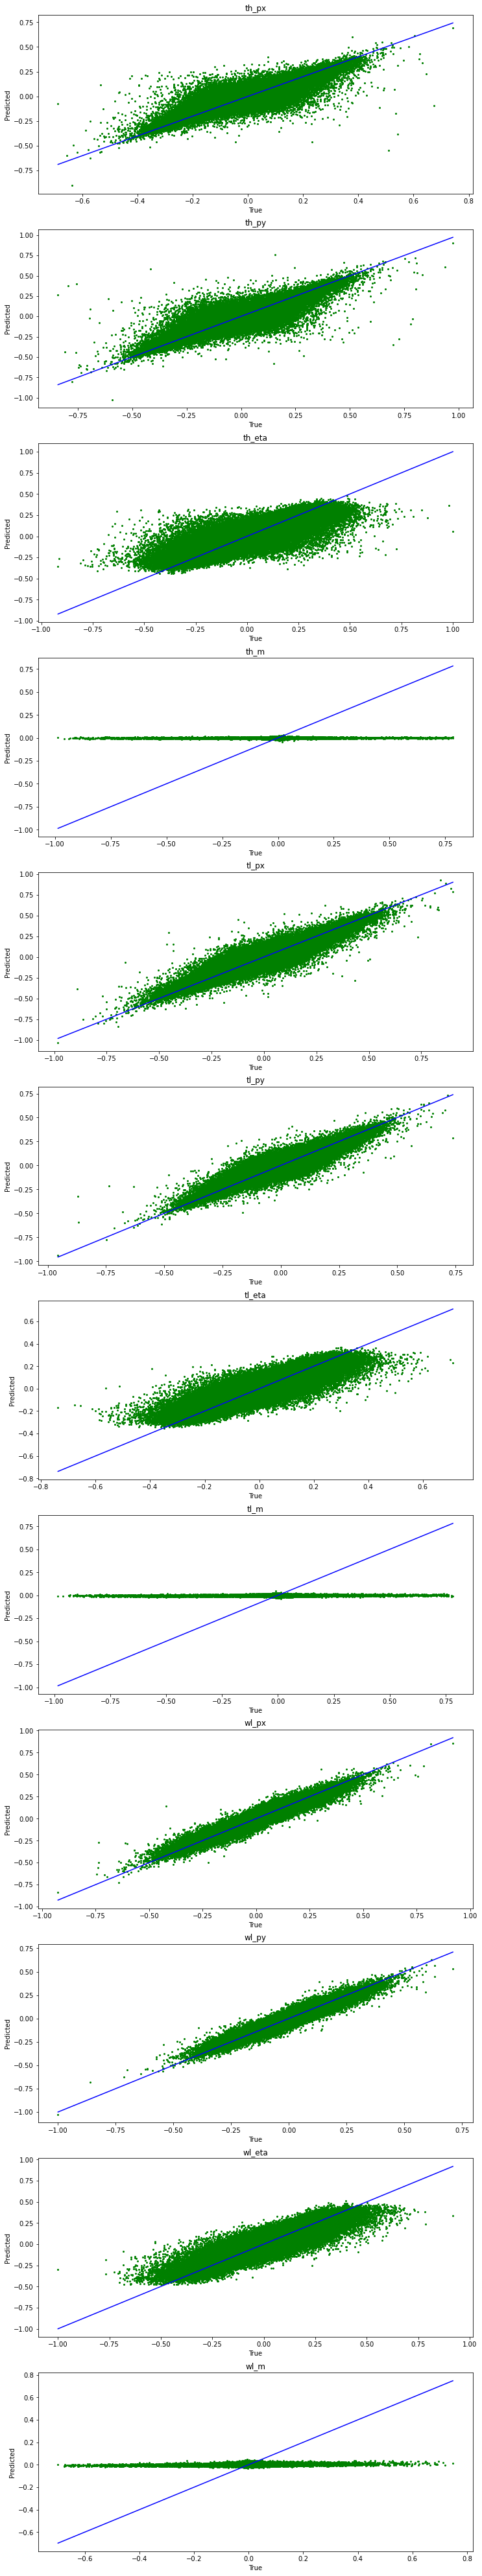

In [14]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [15]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 398.1052318259874
 
th_pt MSE :  2459.5061922282
th_eta MSE :  0.4978331008
th_phi MSE :  0.7711674812
th_m MSE :  34.7221412661
tl_pt MSE :  1586.1381820173
tl_eta MSE :  0.4007215381
tl_phi MSE :  0.4964354765
tl_m MSE :  38.5397226339
wl_pt MSE :  615.3914550245
wl_eta MSE :  0.2918612905
wl_phi MSE :  0.1899957281
wl_m MSE :  35.6039127721


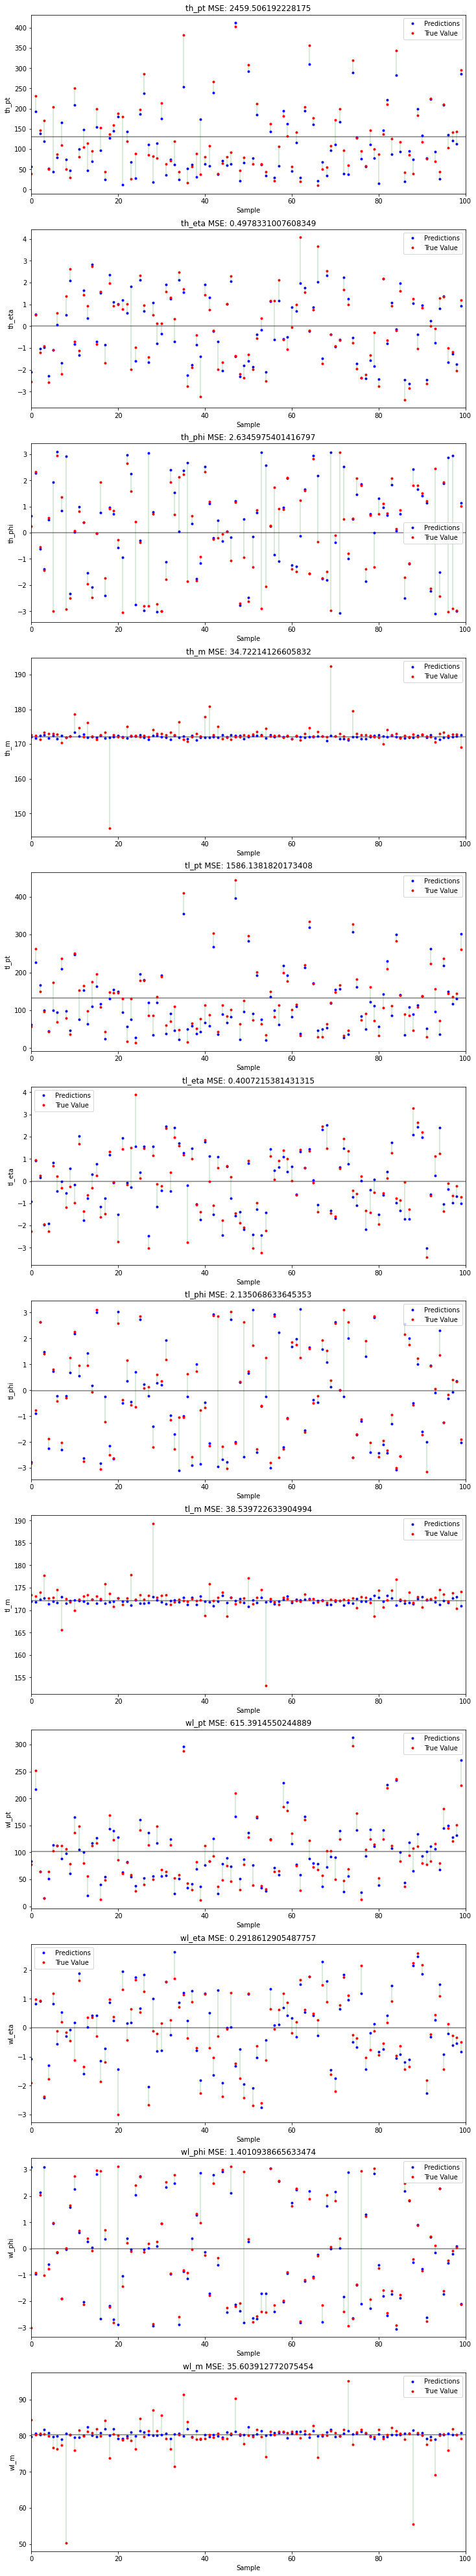

In [16]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

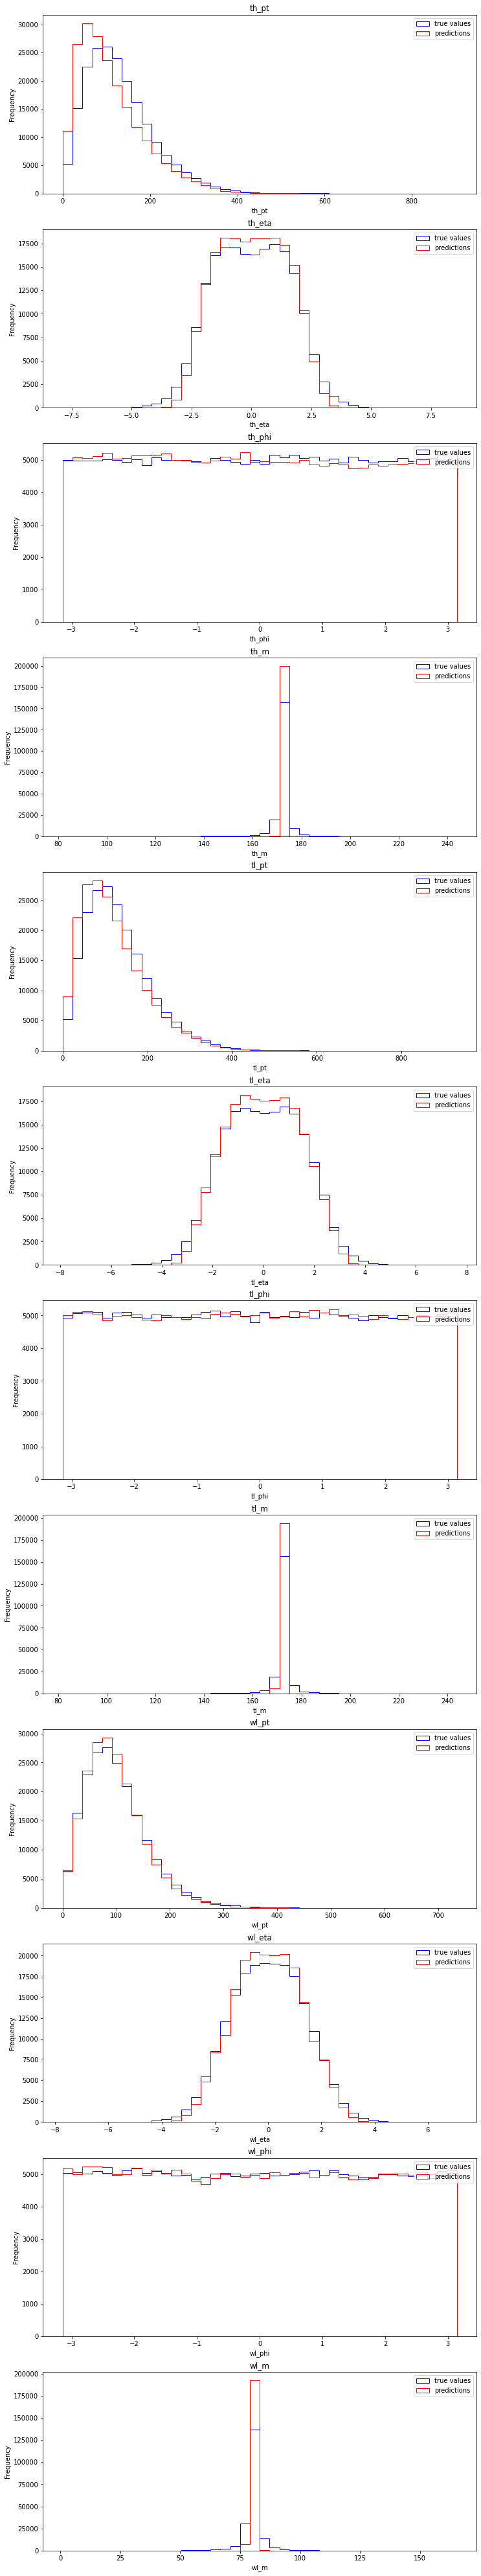

In [17]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

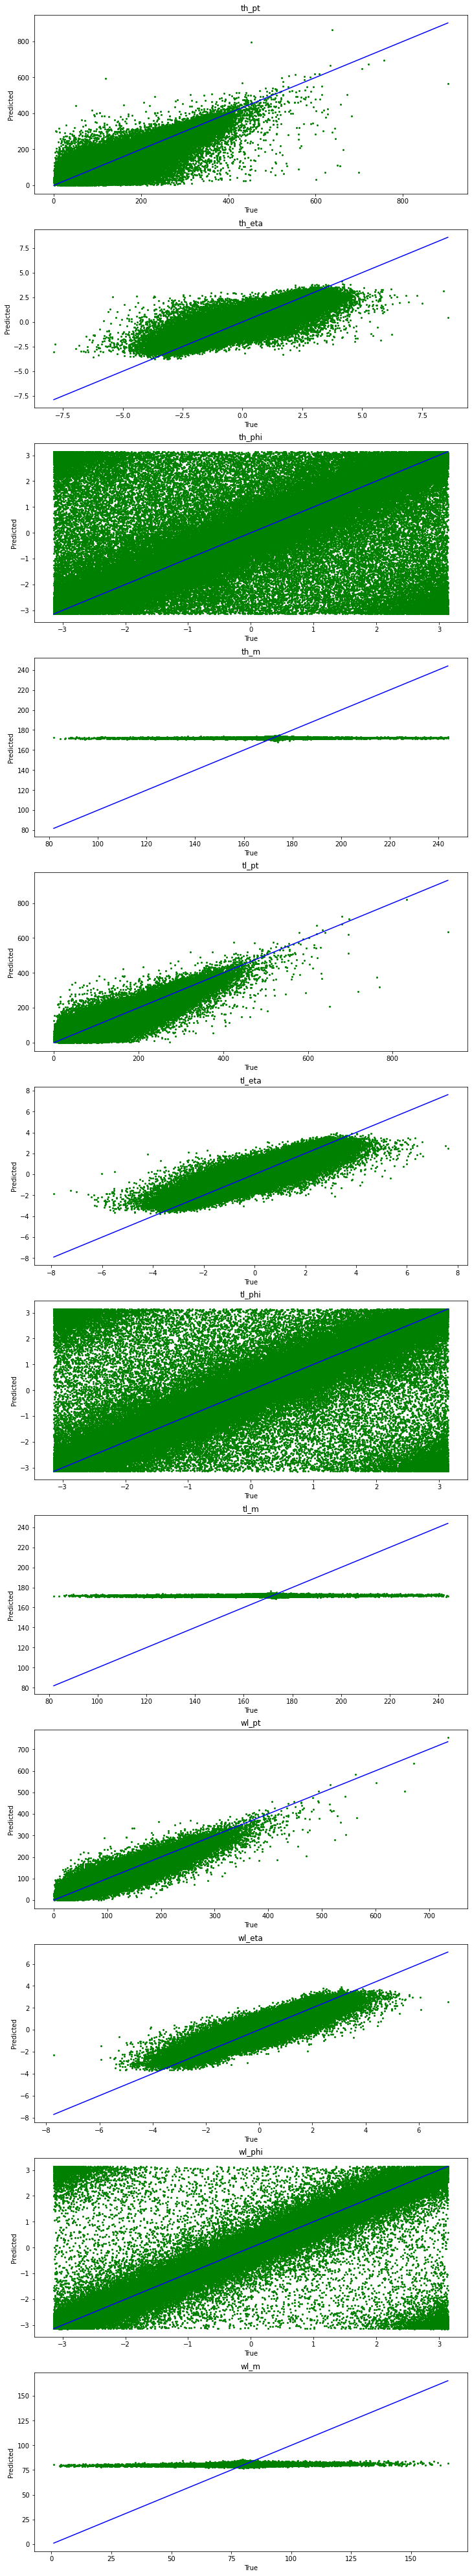

In [18]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

In [19]:
# # weights, biases = model.layers[0].get_weights()


# print(model.layers)

In [20]:
# weights = model.layers[3].get_weights()
# print(weights)

In [21]:
# y = true_origscale[:, 0]
# y1 = predictions_origscale[:, 0]

# plt.figure(figsize=(12,6*len(X_names)))
# for i in range(len(X_names)):
#     plt.subplot(len(X_names), 1, i+1)
#     x = X_total[:,i][split:]
#     name = X_names[i]
#     plt.plot(x, y, 'o', color='b', markersize=2, label='true',)
#     plt.plot(x, y1, 'o', color='g', markersize=2, label='predicted')
#     plt.ylabel('th_pt')
#     plt.xlabel(name)
#     plt.legend()